In [1]:
#importing libraries
import pandas as pd
import numpy as np
import random
import json
from epiweeks import Week, Year
import matplotlib.pyplot as plt
from ipyleaflet import Map, Marker, MarkerCluster, GeoJSON, Polyline
from shapely.geometry import shape, Point, MultiLineString, LineString
import networkx as nx
import dill as pickle
from unidecode import unidecode
from scipy import stats
import seaborn as sns; sns.set()

%matplotlib inline

In [2]:
#dataFrames
#df_bairros = pd.read_csv('../dados/bairrosGeoJson.csv', sep=';')

In [3]:
#dataFrames
df_bairros = pd.read_csv('../dados/bairrosGeoJson.csv', sep=';')
df_bairros_info  = pd.read_csv('../dados/casos_normalizada.csv', sep=';')
df_pontos = pd.read_csv('../dados/ponto_onibus.csv', sep=';')
df_casos = pd.read_csv('../dados/casos_normalizada.csv', sep=';')
df_linhas = pd.read_csv('../dados/linhas.csv', sep=';')
df_linhas = df_linhas[df_linhas['geojson'].apply(lambda x: len(x) > 160)]
df_casos.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
df_analise_grafos = pd.DataFrame()

COLUNAS = ['Bairro', 'TotalDeCasos', 'CasosPorMil', 'TaxaCasosNormalizada', 'TotalDePontos',
 'CentralidadeGrau', 'MediaCentralidadeGrau', 'CentralidadeGrauNormalizada', 
 'CentralidadeAutoVetor', 'MediaCentralidadeAutoVetor', 'CentralidadeAutoVetorNormalizada', 
 'CentralidadeBetweenness', 'MediaCentralidadeBetweenness','CentralidadeBetweennessNormalizada']

# Gera um geom vazio para evitar 
df_analise_grafos = pd.DataFrame(columns=COLUNAS)
df_analise_grafos.columns = COLUNAS

In [6]:
df_analise_grafos['Bairro'] = df_bairros_info['Bairro']
df_analise_grafos['TotalDeCasos'] = df_bairros_info['TotalDeCasos']
df_analise_grafos['CasosPorMil'] = df_bairros_info['CasosPorMil']
df_analise_grafos['TaxaCasosNormalizada'] = 0
df_analise_grafos['CentralidadeGrau'] = 0
df_analise_grafos['TotalDePontos'] = 0
df_analise_grafos['CentralidadeAutoVetor'] = 0
df_analise_grafos['CentralidadeBetweenness'] = 0

In [7]:
#arquivosJson
f_itinerario = open('../dados/itinerario.json')
f_linhas = open('../dados/linhas.json')

itinerario_json = json.load(f_itinerario)
linhas_json = json.load(f_linhas)

In [8]:
#Metodos
def remove_non_ascii(text):
    return unidecode(text)

def estimate_y(x):
    return a * x + b

def lista_pontos_para_geom(pontos):
    markerList = []
    for ponto_id in pontos:
        string1 = MG.nodes[ponto_id[0]]['geoJson'].split('[')    
        string2 = string1[1].split(']')
        coord_str = string2[0].split(',')
        lat = float(coord_str[0].replace("'", ""))
        lon = float(coord_str[1].replace("'", ""))    
        markerList.append(Marker(location=(lat, lon)))
        
    return markerList    

def plotar_lista_geom(markerList):
    m = Map(center=(-25.436889, -49.271532), zoom=13)

    marker_cluster = MarkerCluster(
        markers=markerList
    )

    m.add_layer(marker_cluster);

    return m
    
def printar_lista_pontos(pontos):
    for ponto_id in centralidade_pontos:
        teste = MG.nodes[ponto_id[0]]
        print(f"id: {ponto_id[0]}, n° linhas {ponto_id[1] / 2}, bairro: {teste['bairro']}")
    
def printar_linhas_do_ponto(grafo, ponto):
    # Recupera quais linhas passam por determinado ponto
    linhas_geoJson = []
    sub_grafo_vertices = []
    nos_adjacentes = grafo[ponto]
    for ponto in nos_adjacentes:
        sub_grafo_vertices.append(MG[no_principal][int(ponto)])
        for linha in MG[no_principal][int(ponto)]:
            linha_id = MG[no_principal][int(ponto)][linha]['linha_id']
            if linha_id not in linhas_geoJson:
                linhas_geoJson.append(linha_id)
                
def converter_multigrafo_para_grafo(MG):
    G = nx.Graph()
    for u,v,data in MG.edges(data=True):
        if G.has_edge(u,v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)
    
    return G

def adiciona_centralidade_ao_bairro(lista, tipo):
    for ponto in lista:
        no = MG.nodes[ponto[0]]
        index = df_analise_grafos.loc[df_analise_grafos['Bairro'] == no['bairro']].index
        df_analise_grafos.loc[index, tipo] += ponto[0]
    
    campo = 'Media' + tipo
    for index, row in df_analise_grafos.iterrows():
        df_analise_grafos.loc[index, campo] = df_analise_grafos.loc[index, tipo] / df_analise_grafos.loc[index, 'TotalDePontos'] 

In [9]:
MG = nx.MultiGraph()

In [10]:
# Retira alguns pontos da Regiao metropolitana que ficaram 
# com o campo bairro nulo
df_pontos.dropna(subset=['BAIRRO'], how='all', inplace=True)


In [11]:
# Insere todos os Nos no grafo
for index, ponto in df_pontos.iterrows():    
    casos_bairro = df_casos.loc[df_casos['Bairro'] == ponto['BAIRRO']]
    index = df_analise_grafos.loc[df_analise_grafos['Bairro'] == ponto['BAIRRO']].index
    #print(index)
    df_analise_grafos.loc[index,'TotalDePontos'] += 1
    taxaCasos = float(casos_bairro['TaxaNormalizada'].to_string(index=False))
    
    MG.add_node(
        ponto['PONTO'],
        shape = ponto['shape'],
        geoJson = ponto['geoJson'],
        bairro = ponto['BAIRRO'],
        taxaCasosBairro = taxaCasos,
        peso = 0
    )

In [12]:
# Insere todas as vertices
for linha in linhas_json:    
    cod = linha['COD']
    
    # Esse cara pega diversos etinerarios diferentes
    # Entao filtra apenas 1
    filtered = filter(lambda x: x['COD'] == cod, itinerario_json)
    
    itinerario_completo = list(filtered)
    if (len(itinerario_completo) < 1):            
        continue
        
    itinerario = itinerario_completo[0]['ITINERARY_ID']
    
    # Apenas um etinerario será considerado
    filtered = filter(lambda x: x['ITINERARY_ID'] == itinerario and x['COD'] == cod, itinerario_json)
    sortered = sorted(list(filtered), key=lambda x: int(x['SEQ']))
    
    for i in range(len(sortered) - 1):
        ponto_a_id = int(sortered[i]['NUM'])
        ponto_b_id = int(sortered[i + 1]['NUM'])
        
        ponto_a = df_pontos.loc[df_pontos['PONTO'] == ponto_a_id].head(1)
        ponto_b = df_pontos.loc[df_pontos['PONTO'] == ponto_b_id].head(1)
        
        # Pontos de região metropolitana não estao disponiveis na tabela df_pontos        
        if (len(ponto_a) < 1) | (len(ponto_b) < 1):
            continue
            
        ponto_a_lat = float(ponto_a['LAT'].to_string(index=False))
        ponto_a_lon = float(ponto_a['LON'].to_string(index=False))
                
        ponto_b_lat = float(ponto_b['LAT'].to_string(index=False))
        ponto_b_lon = float(ponto_b['LON'].to_string(index=False))
                        
        line_geoJson = Polyline(locations=[
            [ponto_a_lat, ponto_a_lon],
            [ponto_b_lat, ponto_b_lon]
        ])
        
        line_shape = LineString([(ponto_a_lon, ponto_a_lat), (ponto_b_lon, ponto_b_lat)])        
        
        MG.add_edge(
            ponto_a_id, 
            ponto_b_id, 
            linha_id = cod,
            shape = line_shape,
            geoJson = line_geoJson
        )
        
    ponto_a_id = int(sortered[-1]['NUM'])
    ponto_b_id = int(sortered[0]['NUM'])
    ponto_a = df_pontos.loc[df_pontos['PONTO'] == ponto_a_id].head(1)
    ponto_b = df_pontos.loc[df_pontos['PONTO'] == ponto_b_id].head(1)
    
    if (len(ponto_a) < 1) | (len(ponto_b) < 1):            
        continue
       
    ponto_a_lat = float(ponto_a['LAT'].to_string(index=False))
    ponto_a_lon = float(ponto_a['LON'].to_string(index=False))
                
    ponto_b_lat = float(ponto_b['LAT'].to_string(index=False))
    ponto_b_lon = float(ponto_b['LON'].to_string(index=False))
    
    MG.add_edge(
        ponto_a_id, 
        ponto_b_id, 
        linha_id = cod,
        shape = line_shape,
        geoJson = line_geoJson
    )

In [13]:
# Closing file
f_itinerario.close()
f_linhas.close()

In [14]:
centralidade_pontos_graus = MG.degree(weight='weight')

In [15]:
centralidade_pontos_graus_top =  sorted(dict(centralidade_pontos_graus).items(), key=lambda x: x[1], reverse=True)[:10]

([<matplotlib.axis.YTick at 0x7f76345c7b20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

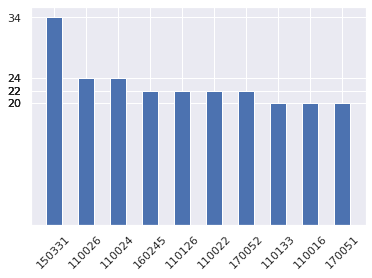

In [16]:
labels, ys = zip(*centralidade_pontos_graus_top)
xs = np.arange(len(labels)) 
width = 0.5
plt.xticks(rotation=45)
plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.yticks(ys)

In [17]:
markerList = lista_pontos_para_geom(centralidade_pontos_graus_top)
plotar_lista_geom(markerList)

Map(center=[-25.436889, -49.271532], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [18]:
adiciona_centralidade_ao_bairro(list(centralidade_pontos_graus), 'CentralidadeGrau')

In [19]:
G = converter_multigrafo_para_grafo(MG)

In [20]:
centralidade_pontos_autovetor = nx.eigenvector_centrality(G,max_iter=400)


In [21]:
centralidade_pontos_autovetor_top = sorted(centralidade_pontos_autovetor.items(), key=lambda x: x[1], reverse=True)[:50]

In [22]:
markerList = lista_pontos_para_geom(centralidade_pontos_autovetor_top)
plotar_lista_geom(markerList)

Map(center=[-25.436889, -49.271532], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [23]:
adiciona_centralidade_ao_bairro(centralidade_pontos_autovetor.items(), 'CentralidadeAutoVetor')

In [24]:
centralidade_pontos_betweenness = nx.betweenness_centrality(G)


In [25]:
centralidade_pontos_betweenness_top = sorted(centralidade_pontos_betweenness.items(), key=lambda x: x[1], reverse=True)[:20]

In [26]:
markerList = lista_pontos_para_geom(centralidade_pontos_betweenness_top)
plotar_lista_geom(markerList)

Map(center=[-25.436889, -49.271532], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [27]:
adiciona_centralidade_ao_bairro(centralidade_pontos_betweenness.items(), 'CentralidadeBetweenness')

In [29]:
df_analise_grafos.head(5)

Bairro  TotalDeCasos  CasosPorMil  TaxaCasosNormalizada  \
0          CENTRO          3790    90.412462                     0   
1   SAO FRANCISCO           507    87.008752                     0   
2   CENTRO CIVICO           163    33.965409                     0   
3  ALTO DA GLORIA           135    24.509804                     0   
4  ALTO DA RUA XV           238    28.397566                     0   

   TotalDePontos  CentralidadeGrau MediaCentralidadeGrau  \
0            574          24668614               42976.7   
1            175           4646592                 26552   
2            204           4242255               20795.4   
3             60           2590285               43171.4   
4            138           5826130               42218.3   

  CentralidadeGrauNormalizada  CentralidadeAutoVetor  \
0                         NaN               21595210   
1                         NaN                4205267   
2                         NaN                4133214   
3                         NaN                1822103   
4                         NaN                4901776   

  MediaCentralidadeAutoVetor CentralidadeAutoVetorNormalizada  \
0                    37622.3                              NaN   
1                    24030.1                              NaN   
2                    20260.9                              NaN   
3                    30368.4                              NaN   
4                    35520.1                              NaN   

   CentralidadeBetweenness MediaCentralidadeBetweenness  \
0                 21595210                      37622.3   
1                  4205267                      24030.1   
2                  4133214                      20260.9   
3                  1822103                      30368.4   
4                  4901776                      35520.1   

  CentralidadeBetweennessNormalizada  
0                                NaN  
1                                NaN  
2                                NaN  
3                                NaN  
4                                NaN

In [30]:
maximo = df_analise_grafos['CasosPorMil'].max()
minimo = df_analise_grafos['CasosPorMil'].min()
dif = maximo - minimo

df_analise_grafos['TaxaCasosNormalizada'] = (df_analise_grafos['CasosPorMil'] - minimo) / dif

In [31]:
maximo = df_analise_grafos['MediaCentralidadeGrau'].max()
minimo = df_analise_grafos['MediaCentralidadeGrau'].min()
dif = maximo - minimo

df_analise_grafos['CentralidadeGrauNormalizada'] = (df_analise_grafos['MediaCentralidadeGrau'] - minimo) / dif

In [32]:
maximo = df_analise_grafos['CentralidadeAutoVetor'].max()
minimo = df_analise_grafos['CentralidadeAutoVetor'].min()
dif = maximo - minimo

df_analise_grafos['CentralidadeAutoVetorNormalizada'] = (df_analise_grafos['CentralidadeAutoVetor'] - minimo) / dif

In [33]:
maximo = df_analise_grafos['CentralidadeBetweenness'].max()
minimo = df_analise_grafos['CentralidadeBetweenness'].min()
dif = maximo - minimo

df_analise_grafos['CentralidadeBetweennessNormalizada'] = (df_analise_grafos['CentralidadeBetweenness'] - minimo) / dif

<AxesSubplot:xlabel='Bairro'>

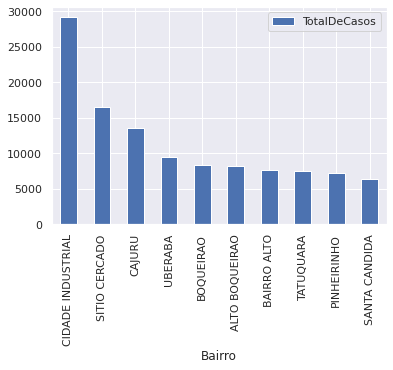

In [34]:
top_10 = df_analise_grafos[['Bairro','TotalDeCasos']].set_index('Bairro').sort_values('TotalDeCasos', ascending=False).head(10)
top_10.plot.bar()

In [35]:
df_bairros['nome'].iloc[2] = 'CIDADE INDUSTRIAL'
top_10_layer = df_bairros[df_bairros['nome'].apply(lambda x: remove_non_ascii(x)).isin(top_10.index)]

In [36]:
#geojsonFeature_bairro = json.loads(teste_bairro['geojson'])
# Teste plot bairros
m = Map(center=(-25.4669137296822,-49.1969392947261), zoom=12)

for index, bairro in top_10_layer.iterrows():
    geo_json = GeoJSON(
        data=json.loads(bairro['geojson'])
    )
    m.add_layer(geo_json)

m

Map(center=[-25.4669137296822, -49.1969392947261], controls=(ZoomControl(options=['position', 'zoom_in_text', …

<AxesSubplot:xlabel='Bairro'>

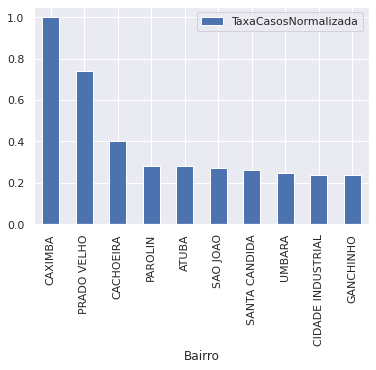

In [37]:
top_10 = df_analise_grafos[['Bairro','TaxaCasosNormalizada']].set_index('Bairro').sort_values('TaxaCasosNormalizada', ascending=False).head(10)
top_10.plot.bar()

In [38]:
df_bairros['nome'].iloc[2] = 'CIDADE INDUSTRIAL'
top_10_layer = df_bairros[df_bairros['nome'].apply(lambda x: remove_non_ascii(x)).isin(top_10.index)]

In [39]:
#geojsonFeature_bairro = json.loads(teste_bairro['geojson'])
# Teste plot bairros
m = Map(center=(-25.4669137296822,-49.1969392947261), zoom=12)

for index, bairro in top_10_layer.iterrows():
    geo_json = GeoJSON(
        data=json.loads(bairro['geojson'])
    )
    m.add_layer(geo_json)

m

Map(center=[-25.4669137296822, -49.1969392947261], controls=(ZoomControl(options=['position', 'zoom_in_text', …

<AxesSubplot:xlabel='TaxaCasosNormalizada'>

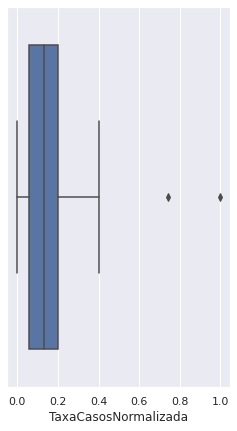

In [40]:
fig, ax = plt.subplots(figsize=(4, 7))

sns.boxplot(x=df_analise_grafos["TaxaCasosNormalizada"])

<AxesSubplot:>

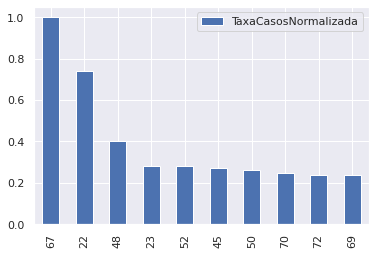

In [41]:
df_analise_grafos[['Bairro','TaxaCasosNormalizada']].sort_values('TaxaCasosNormalizada', ascending=False).head(10).plot.bar()

In [42]:
# Retira outliers da taxa de casos
df_analise_grafos_sem_outlier = df_analise_grafos.drop([67])
df_analise_grafos_sem_outlier = df_analise_grafos_sem_outlier.drop([22])
df_analise_grafos_sem_outlier = df_analise_grafos_sem_outlier.drop([48])

<AxesSubplot:xlabel='CentralidadeGrauNormalizada'>

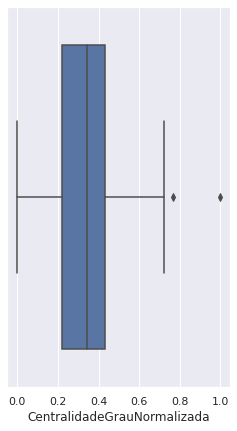

In [43]:
fig, ax = plt.subplots(figsize=(4, 7))

sns.boxplot(x=df_analise_grafos["CentralidadeGrauNormalizada"])

<AxesSubplot:>

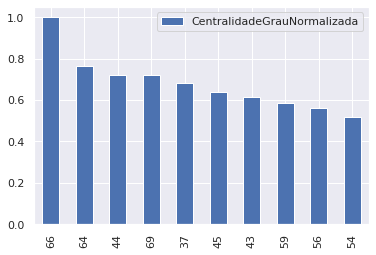

In [44]:
df_analise_grafos[['Bairro','CentralidadeGrauNormalizada']].sort_values('CentralidadeGrauNormalizada', ascending=False).head(10).plot.bar()

In [45]:
# Retira Outlier da taxa de centralidade de Grau
df_analise_grafos_sem_outlier = df_analise_grafos_sem_outlier.drop([66])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='CentralidadeGrauNormalizada', ylabel='TaxaCasosNormalizada'>

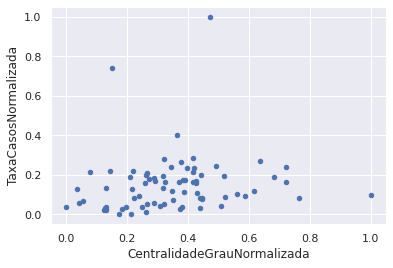

In [46]:
df_analise_grafos.plot.scatter(x = 'CentralidadeGrauNormalizada', y = 'TaxaCasosNormalizada')

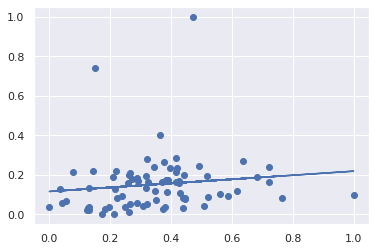

In [47]:
x = list(df_analise_grafos['CentralidadeGrauNormalizada'])
y = df_analise_grafos['TaxaCasosNormalizada']
a, b, r, p, std_err = stats.linregress(x,y)
df_analise_grafos['y_estimated'] = df_analise_grafos['CentralidadeGrauNormalizada'].apply(estimate_y)
plt.figure()
plt.plot(df_analise_grafos['CentralidadeGrauNormalizada'],df_analise_grafos['y_estimated'])
plt.scatter(df_analise_grafos['CentralidadeGrauNormalizada'], df_analise_grafos['TaxaCasosNormalizada'])
plt.show()

In [48]:
print("R-squared: %f" % r **2)

R-squared: 0.016461


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='CentralidadeGrauNormalizada', ylabel='TaxaCasosNormalizada'>

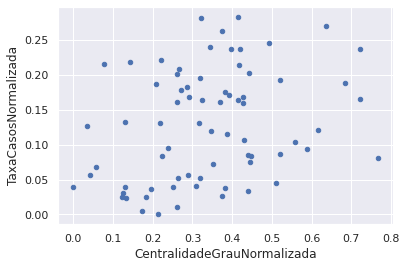

In [49]:
df_analise_grafos_sem_outlier.plot.scatter(x = 'CentralidadeGrauNormalizada', y = 'TaxaCasosNormalizada')

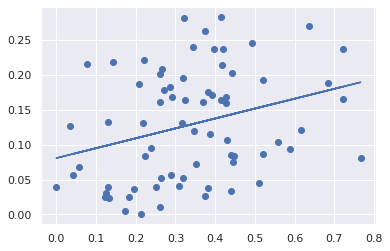

In [50]:
x = list(df_analise_grafos_sem_outlier['CentralidadeGrauNormalizada'])
y = df_analise_grafos_sem_outlier['TaxaCasosNormalizada']
a, b, r, p, std_err = stats.linregress(x,y)
df_analise_grafos_sem_outlier['y_estimated'] = df_analise_grafos_sem_outlier['CentralidadeGrauNormalizada'].apply(estimate_y)
plt.figure()
plt.plot(df_analise_grafos_sem_outlier['CentralidadeGrauNormalizada'],df_analise_grafos_sem_outlier['y_estimated'])
plt.scatter(df_analise_grafos_sem_outlier['CentralidadeGrauNormalizada'], df_analise_grafos_sem_outlier['TaxaCasosNormalizada'])
plt.show()

In [51]:
print("R-squared: %f" % r **2)

R-squared: 0.092444


<AxesSubplot:xlabel='CentralidadeAutoVetorNormalizada'>

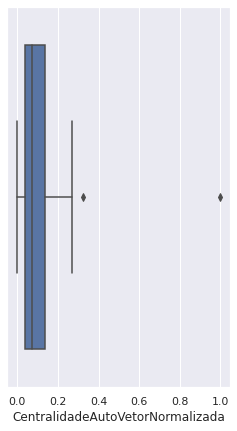

In [52]:
fig, ax = plt.subplots(figsize=(4, 7))

sns.boxplot(x=df_analise_grafos["CentralidadeAutoVetorNormalizada"])

<AxesSubplot:>

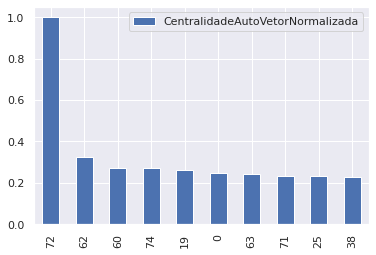

In [53]:
df_analise_grafos[['Bairro','CentralidadeAutoVetorNormalizada']].sort_values('CentralidadeAutoVetorNormalizada', ascending=False).head(10).plot.bar()

In [54]:
# Retira Outlier da taxa de centralidade de autovetor
df_analise_grafos_sem_outlier = df_analise_grafos_sem_outlier.drop([72])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='CentralidadeAutoVetorNormalizada', ylabel='TaxaCasosNormalizada'>

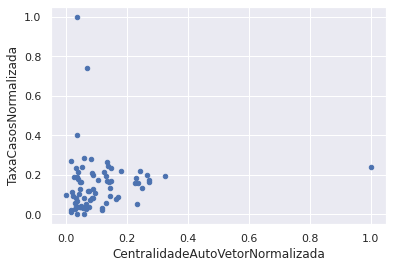

In [55]:
df_analise_grafos.plot.scatter(x = 'CentralidadeAutoVetorNormalizada', y = 'TaxaCasosNormalizada')

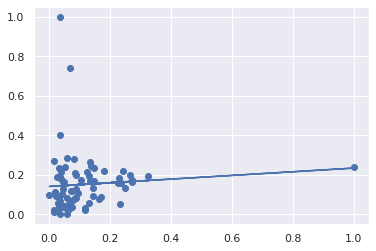

In [56]:
x = list(df_analise_grafos['CentralidadeAutoVetorNormalizada'])
y = df_analise_grafos['TaxaCasosNormalizada']
a, b, r, p, std_err = stats.linregress(x,y)
df_analise_grafos['y_estimated'] = df_analise_grafos['CentralidadeAutoVetorNormalizada'].apply(estimate_y)
plt.figure()
plt.plot(df_analise_grafos['CentralidadeAutoVetorNormalizada'],df_analise_grafos['y_estimated'])
plt.scatter(df_analise_grafos['CentralidadeAutoVetorNormalizada'], df_analise_grafos['TaxaCasosNormalizada'])
plt.show()

In [57]:
print("R-squared: %f" % r **2)

R-squared: 0.006561


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='CentralidadeAutoVetorNormalizada', ylabel='TaxaCasosNormalizada'>

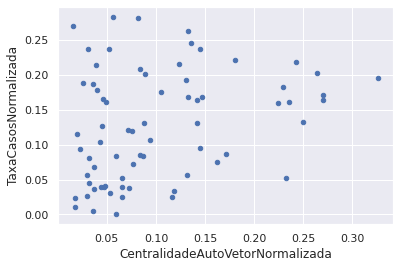

In [58]:
df_analise_grafos_sem_outlier.plot.scatter(x = 'CentralidadeAutoVetorNormalizada', y = 'TaxaCasosNormalizada')

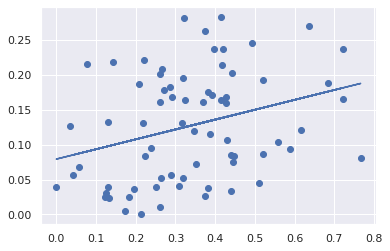

In [59]:
x = list(df_analise_grafos_sem_outlier['CentralidadeAutoVetorNormalizada'])
y = df_analise_grafos_sem_outlier['TaxaCasosNormalizada']
a, b, r, p, std_err = stats.linregress(x,y)
df_analise_grafos_sem_outlier['y_estimated'] = df_analise_grafos_sem_outlier['CentralidadeAutoVetorNormalizada'].apply(estimate_y)
plt.figure()
plt.plot(df_analise_grafos_sem_outlier['CentralidadeAutoVetorNormalizada'],df_analise_grafos_sem_outlier['y_estimated'])
plt.scatter(df_analise_grafos_sem_outlier['CentralidadeAutoVetorNormalizada'], df_analise_grafos_sem_outlier['TaxaCasosNormalizada'])
plt.show()

In [60]:
print("R-squared: %f" % r **2)

R-squared: 0.094746


<AxesSubplot:xlabel='CentralidadeBetweennessNormalizada'>

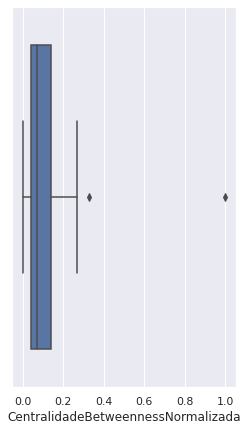

In [61]:
fig, ax = plt.subplots(figsize=(4, 7))

sns.boxplot(x=df_analise_grafos["CentralidadeBetweennessNormalizada"])

<AxesSubplot:>

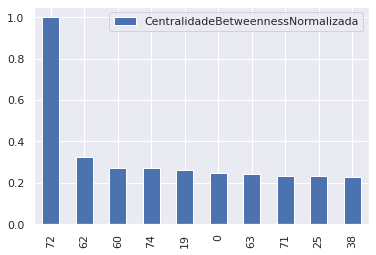

In [62]:
df_analise_grafos[['Bairro','CentralidadeBetweennessNormalizada']].sort_values('CentralidadeBetweennessNormalizada', ascending=False).head(10).plot.bar()

In [63]:
# Retira Outlier da taxa de centralidade de autovetor
#df_analise_grafos_sem_outlier = df_analise_grafos_sem_outlier.drop([72])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='CentralidadeBetweennessNormalizada', ylabel='TaxaCasosNormalizada'>

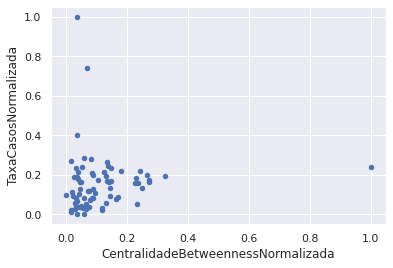

In [64]:
df_analise_grafos.plot.scatter(x = 'CentralidadeBetweennessNormalizada', y = 'TaxaCasosNormalizada')

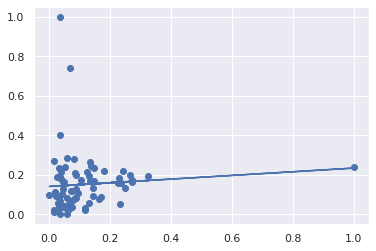

In [65]:
x = list(df_analise_grafos['CentralidadeBetweennessNormalizada'])
y = df_analise_grafos['TaxaCasosNormalizada']
a, b, r, p, std_err = stats.linregress(x,y)
df_analise_grafos['y_estimated'] = df_analise_grafos['CentralidadeBetweennessNormalizada'].apply(estimate_y)
plt.figure()
plt.plot(df_analise_grafos['CentralidadeBetweennessNormalizada'],df_analise_grafos['y_estimated'])
plt.scatter(df_analise_grafos['CentralidadeBetweennessNormalizada'], df_analise_grafos['TaxaCasosNormalizada'])
plt.show()

In [66]:
print("R-squared: %f" % r **2)

R-squared: 0.006561


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='CentralidadeBetweennessNormalizada', ylabel='TaxaCasosNormalizada'>

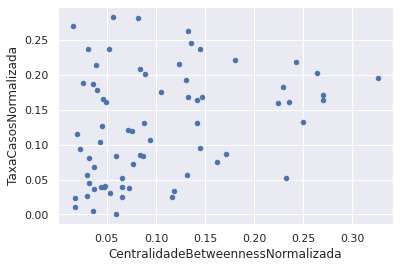

In [67]:
df_analise_grafos_sem_outlier.plot.scatter(x = 'CentralidadeBetweennessNormalizada', y = 'TaxaCasosNormalizada')

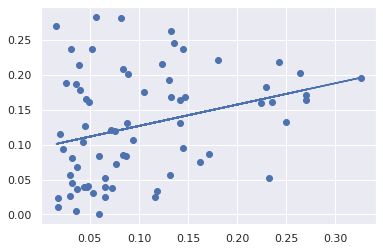

In [68]:
x = list(df_analise_grafos_sem_outlier['CentralidadeBetweennessNormalizada'])
y = df_analise_grafos_sem_outlier['TaxaCasosNormalizada']
a, b, r, p, std_err = stats.linregress(x,y)
df_analise_grafos_sem_outlier['y_estimated'] = df_analise_grafos_sem_outlier['CentralidadeBetweennessNormalizada'].apply(estimate_y)
plt.figure()
plt.plot(df_analise_grafos_sem_outlier['CentralidadeBetweennessNormalizada'],df_analise_grafos_sem_outlier['y_estimated'])
plt.scatter(df_analise_grafos_sem_outlier['CentralidadeBetweennessNormalizada'], df_analise_grafos_sem_outlier['TaxaCasosNormalizada'])
plt.show()

In [69]:
print("R-squared: %f" % r **2)

R-squared: 0.088306


In [85]:
df_corr = df_analise_grafos_sem_outlier.corr()
df_corr = df_corr.style.background_gradient(cmap='RdBu')
df_corr

In [70]:
df_bairros_info.columns

Index(['Unnamed: 0', 'Bairro', 'totalHab', 'mulheres', 'homens', 'menos24',
       '25a65', 'mais66', 'menos1SM', '1a2SM', '2a4SM', '4a10SM', '10MaisSM',
       'semInstru', 'PrimGrau', 'SegGrau', 'TercGrau', 'Mestrado/doutorado',
       'TotalDeCasos', 'CasosPorMil', 'TaxaNormalizada'],
      dtype='object')

In [75]:
df_corr = df_bairros_info.corr()
df_corr = df_corr.style.background_gradient(cmap='RdBu')
df_corr

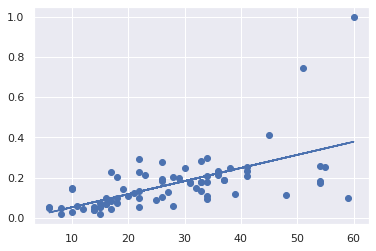

In [72]:
x = df_bairros_info['semInstru']
y = df_bairros_info['TaxaNormalizada']
a, b, r, p, std_err = stats.linregress(x,y)
df_bairros_info['y_estimated'] = df_bairros_info['semInstru'].apply(estimate_y)
plt.figure()
plt.plot(df_bairros_info['semInstru'],df_bairros_info['y_estimated'])
plt.scatter(df_bairros_info['semInstru'], df_bairros_info['TaxaNormalizada'])
plt.show()

In [73]:
print("R-squared: %f" % r **2)

R-squared: 0.366295


In [83]:
from statsmodels.formula.api import ols

model = ols("TaxaNormalizada ~ semInstru + PrimGrau + SegGrau + TercGrau", data=df_bairros_info)
response = model.fit()
response.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        TaxaNormalizada   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     10.40
Date:                Sat, 22 May 2021   Prob (F-statistic):           1.14e-06
Time:                        01:35:51   Log-Likelihood:                 56.386
No. Observations:                  75   AIC:                            -102.8
Df Residuals:                      70   BIC:                            -91.18
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2107      0.344     -0.612      0.543      -0.898       0.476
semInstru      0.0077      0.003      2.226      0.029       0.001       0.015
PrimGrau       0.0032      0.004      0.741      0.461      -0.005       0.012
SegGrau        0.0024      0.004      0.593      0.555      -0.006       0.010
TercGrau       0.0019      0.005      0.401      0.689      -0.007       0.011
==============================================================================
Omnibus:                       71.802   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.846
Skew:                           2.775   Prob(JB):                    3.11e-139
Kurtosis:                      16.165   Cond. No.                     1.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
model = ols("TaxaCasosNormalizada ~ CentralidadeAutoVetorNormalizada + CentralidadeBetweennessNormalizada", data=df_analise_grafos_sem_outlier)
response = model.fit()
response.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     TaxaCasosNormalizada   R-squared:                       0.088
Model:                              OLS   Adj. R-squared:                  0.075
Method:                   Least Squares   F-statistic:                     6.586
Date:                  Sat, 22 May 2021   Prob (F-statistic):             0.0125
Time:                          01:45:14   Log-Likelihood:                 82.429
No. Observations:                    70   AIC:                            -160.9
Df Residuals:                        68   BIC:                            -156.4
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.0962      0.015      6.376      0.000       0.066       0.126
CentralidadeAutoVetorNormalizada       0.1528      0.060      2.566      0.012       0.034       0.272
CentralidadeBetweennessNormalizada     0.1528      0.060      2.566      0.012       0.034       0.272
==============================================================================
Omnibus:                        4.816   Durbin-Watson:                   0.944
Prob(Omnibus):                  0.090   Jarque-Bera (JB):                3.959
Skew:                           0.476   Prob(JB):                        0.138
Kurtosis:                       2.327   Cond. No.                     6.58e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.65e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""